In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import time

In [2]:
# --- Step 1: List of kabupaten/kota
places = [
    "Pontianak, Kalimantan Barat",
    "Kubu Raya, Kalimantan Barat",
    "Landak, Kalimantan Barat",
    "Bengkayang, Kalimantan Barat",
    "Singkawang, Kalimantan Barat",
    "Sambas, Kalimantan Barat",
    "Sanggau, Kalimantan Barat",
    "Sekadau, Kalimantan Barat",
    "Mempawah, Kalimantan Barat",
    "Sintang, Kalimantan Barat",
    "Melawi, Kalimantan Barat",
    "Kapuas Hulu, Kalimantan Barat",
    "Kayong Utara, Kalimantan Barat",
    "Ketapang, Kalimantan Barat"
]

# --- Step 2: Geocode
print("Geocoding...")
locations = [ox.geocode(place) for place in places]

# --- Step 3: Load road network
print("Downloading Kalimantan Barat road network...")
G = ox.graph_from_place("Kalimantan Barat, Indonesia", network_type='drive')
G = ox.distance.add_edge_lengths(G)

Geocoding...


c:\Code\Python 3.10.9\environments\RM\lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 132 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [3]:
# --- Step 4: Get nodes
nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in locations]

In [4]:
# --- Step 5: Create Dijkstra distance matrix
print("Calculating pairwise distances...")
n = len(nodes)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            try:
                dist_matrix[i][j] = nx.shortest_path_length(G, nodes[i], nodes[j], weight='length')
            except:
                dist_matrix[i][j] = 1e6  # large value for unreachable

# --- Step 6: NN
def nn (matrix, start=0):
    n = len(matrix)
    visited = [False] * n
    path = [start]
    visited[start] = True
    current = start
    for _ in range(n - 1):
        next_city = np.argmin([matrix[current][j] if not visited[j] else np.inf for j in range(n)])
        path.append(next_city)
        visited[next_city] = True
        current = next_city
    return path

def route_distance(route, matrix):
    return sum(matrix[route[i]][route[i+1]] for i in range(len(route)-1))



Calculating pairwise distances...


In [5]:
# Run nn
start_time = time.perf_counter()
nn_route = nn(dist_matrix)
nn_route.append(nn_route[0])
nn_distance = route_distance(nn_route, dist_matrix)
nn_time = time.perf_counter() - start_time

# --- Step 7: Solve TSP with GLS
def solve_tsp(matrix):
    tsp_size = len(matrix)
    manager = pywrapcp.RoutingIndexManager(tsp_size, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        from_node = manager.IndexToNode(from_idx)
        to_node = manager.IndexToNode(to_idx)
        return int(matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Search strategy
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_params)
    if solution:
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # add end
        return route
    else:
        return None


# Run GLS
start_time = time.perf_counter()
opt_route = solve_tsp(dist_matrix)
opt_distance = route_distance(opt_route, dist_matrix)
opt_time = time.perf_counter() - start_time

In [6]:
# --- Step 8: Results
print("\n========== COMPARISON ==========")

print("\n Nearest Neighbor:")
for idx in nn_route:
    print(f" - {places[idx]}")
print(f"Total distance: {nn_distance / 1000:.2f} km")
print(f"Execution time: {nn_time:.6f} s")

print("\nOptimal TSP Route (GLS):")
for idx in opt_route:
    print(f" - {places[idx]}")
print(f"Total distance: {opt_distance / 1000:.2f} km")
print(f"Execution time: {opt_time:.6f} s")


========== COMPARISON ==========

 Nearest Neighbor:
 - Pontianak, Kalimantan Barat
 - Kubu Raya, Kalimantan Barat
 - Landak, Kalimantan Barat
 - Bengkayang, Kalimantan Barat
 - Singkawang, Kalimantan Barat
 - Sambas, Kalimantan Barat
 - Sanggau, Kalimantan Barat
 - Sekadau, Kalimantan Barat
 - Mempawah, Kalimantan Barat
 - Sintang, Kalimantan Barat
 - Melawi, Kalimantan Barat
 - Kapuas Hulu, Kalimantan Barat
 - Kayong Utara, Kalimantan Barat
 - Ketapang, Kalimantan Barat
 - Pontianak, Kalimantan Barat
Total distance: 2560.27 km
Execution time: 0.000644 s

Optimal TSP Route (GLS):
 - Pontianak, Kalimantan Barat
 - Singkawang, Kalimantan Barat
 - Sambas, Kalimantan Barat
 - Bengkayang, Kalimantan Barat
 - Landak, Kalimantan Barat
 - Sanggau, Kalimantan Barat
 - Sekadau, Kalimantan Barat
 - Melawi, Kalimantan Barat
 - Sintang, Kalimantan Barat
 - Kapuas Hulu, Kalimantan Barat
 - Mempawah, Kalimantan Barat
 - Ketapang, Kalimantan Barat
 - Kayong Utara, Kalimantan Barat
 - Kubu Raya, Kali

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Assume: nodes[i] is the OSM node for city i
def expand_route(route_index_list, nodes, G):
    full_route = []
    for i in range(len(route_index_list) - 1):
        source = nodes[route_index_list[i]]
        target = nodes[route_index_list[i + 1]]
        path = nx.shortest_path(G, source=source, target=target, weight='length')
        full_route += path if i == 0 else path[1:]  # avoid duplicate nodes
    return full_route


In [8]:
nn_node_route = expand_route(nn_route, nodes, G)
opt_node_route = expand_route(opt_route, nodes, G)


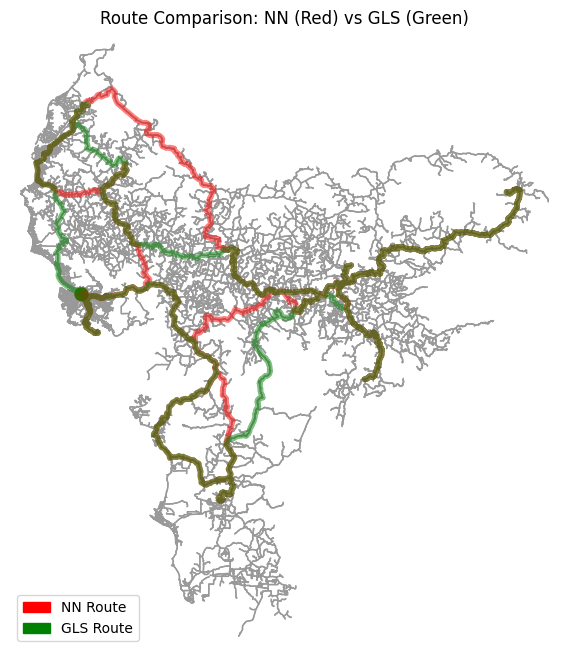

In [9]:
fig, ax = ox.plot_graph_routes(
    G,
    routes=[nn_node_route, opt_node_route],
    route_colors=['red', 'green'],
    route_linewidth=4,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# Add a legend manually
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='NN Route')
green_patch = mpatches.Patch(color='green', label='GLS Route')
plt.legend(handles=[red_patch, green_patch], loc='lower left')
plt.title("Route Comparison: NN (Red) vs GLS (Green)")
plt.show()


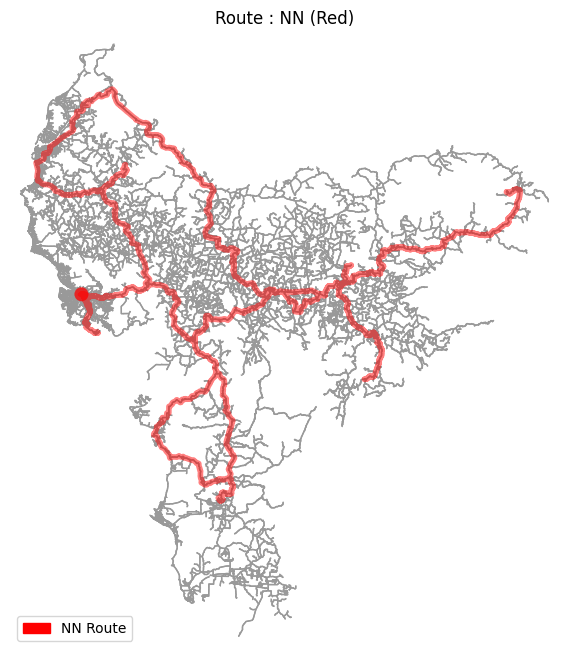

In [10]:
fig, ax = ox.plot_graph_routes(
    G,
    routes=[nn_node_route],
    route_colors=['red'],
    route_linewidth=4,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# Add a legend manually
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='NN Route')
plt.legend(handles=[red_patch], loc='lower left')
plt.title("Route : NN (Red)")
plt.show()

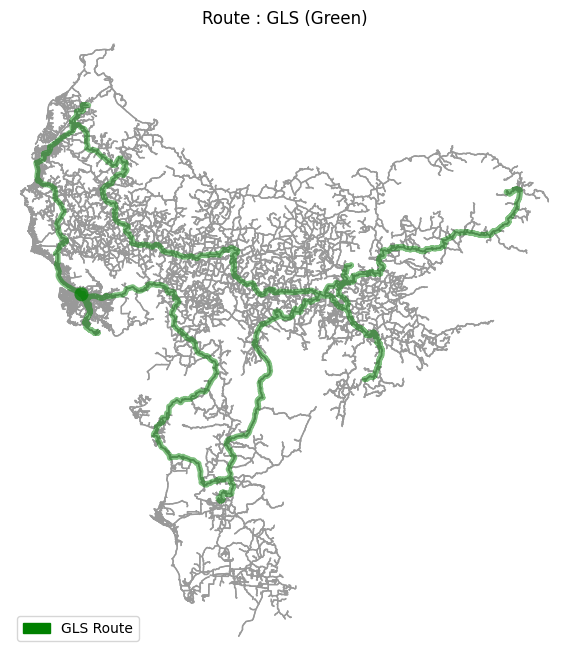

In [11]:
fig, ax = ox.plot_graph_routes(
    G,
    routes=[opt_node_route],
    route_colors=['green'],
    route_linewidth=4,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# Add a legend manually
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='GLS Route')
plt.legend(handles=[green_patch], loc='lower left')
plt.title("Route : GLS (Green)")
plt.show()

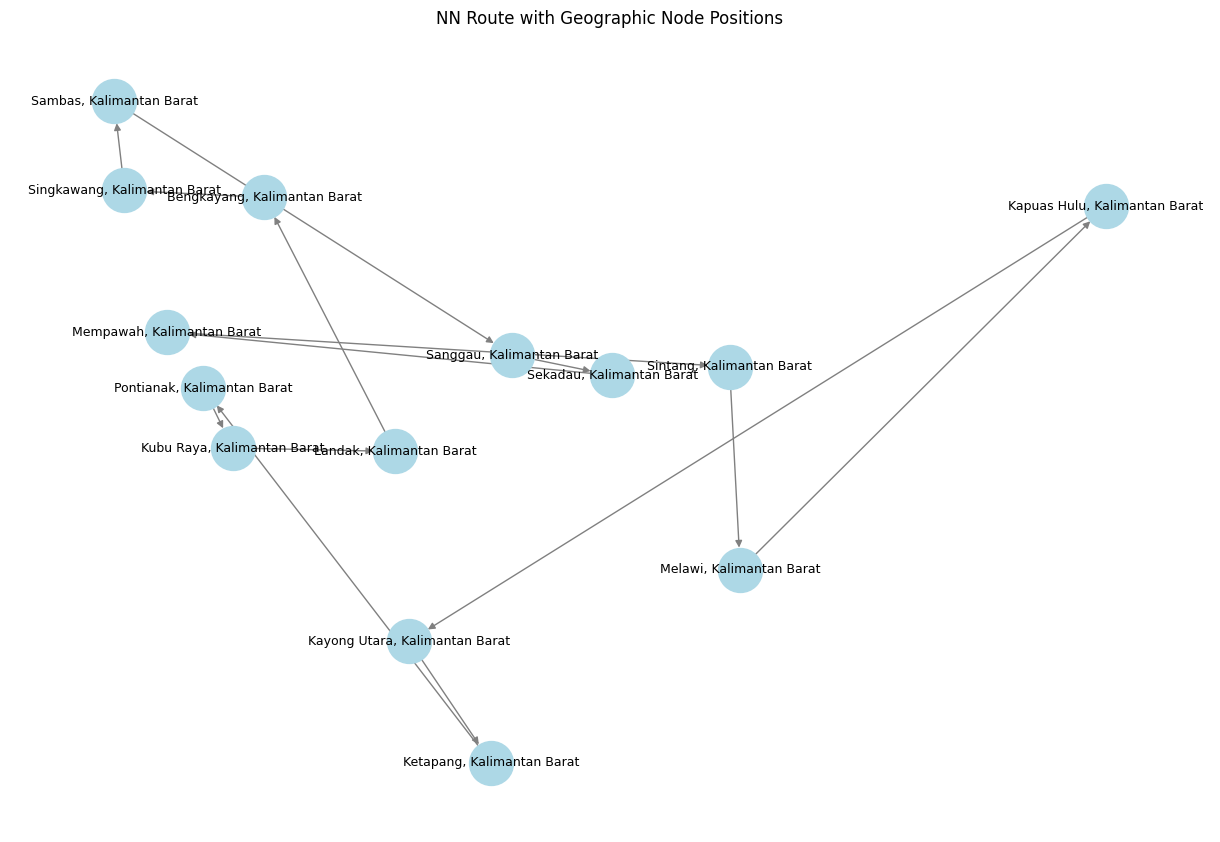

In [12]:
geo_pos = {
    0: (109.3333, -0.0333),   # Pontianak
    1: (109.4544, -0.3201),   # Kubu Raya
    2: (110.1216, -0.3367),   # Landak
    3: (109.5840, 0.8758),    # Bengkayang
    4: (109.0093, 0.9087),    # Singkawang
    5: (108.9667, 1.3333),    # Sambas
    6: (110.6031, 0.1239),    # Sanggau
    7: (111.0134, 0.0261),    # Sekadau
    8: (109.1833, 0.2333),    # Mempawah
    9: (111.4960, 0.0679),    # Sintang
    10: (111.5400, -0.9000),  # Melawi
    11: (113.0426, 0.8354),   # Kapuas Hulu (Putussibau)
    12: (110.1794, -1.2415),  # Kayong Utara (Sukadana)
    13: (110.5161, -1.8210),  # Ketapang
}

import networkx as nx
import matplotlib.pyplot as plt

# Example route: NN route (index-based)
nn_route = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]
edges = [(nn_route[i], nn_route[i+1]) for i in range(len(nn_route) - 1)]

# Build graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Labels (optional): only short city names
labels = {i: places[i] for i in G.nodes()}

# Draw graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos=geo_pos, with_labels=True, labels=labels,
        node_color='lightblue', node_size=1000,
        font_size=9, edge_color='gray', arrows=True)
plt.title("NN Route with Geographic Node Positions")
plt.show()


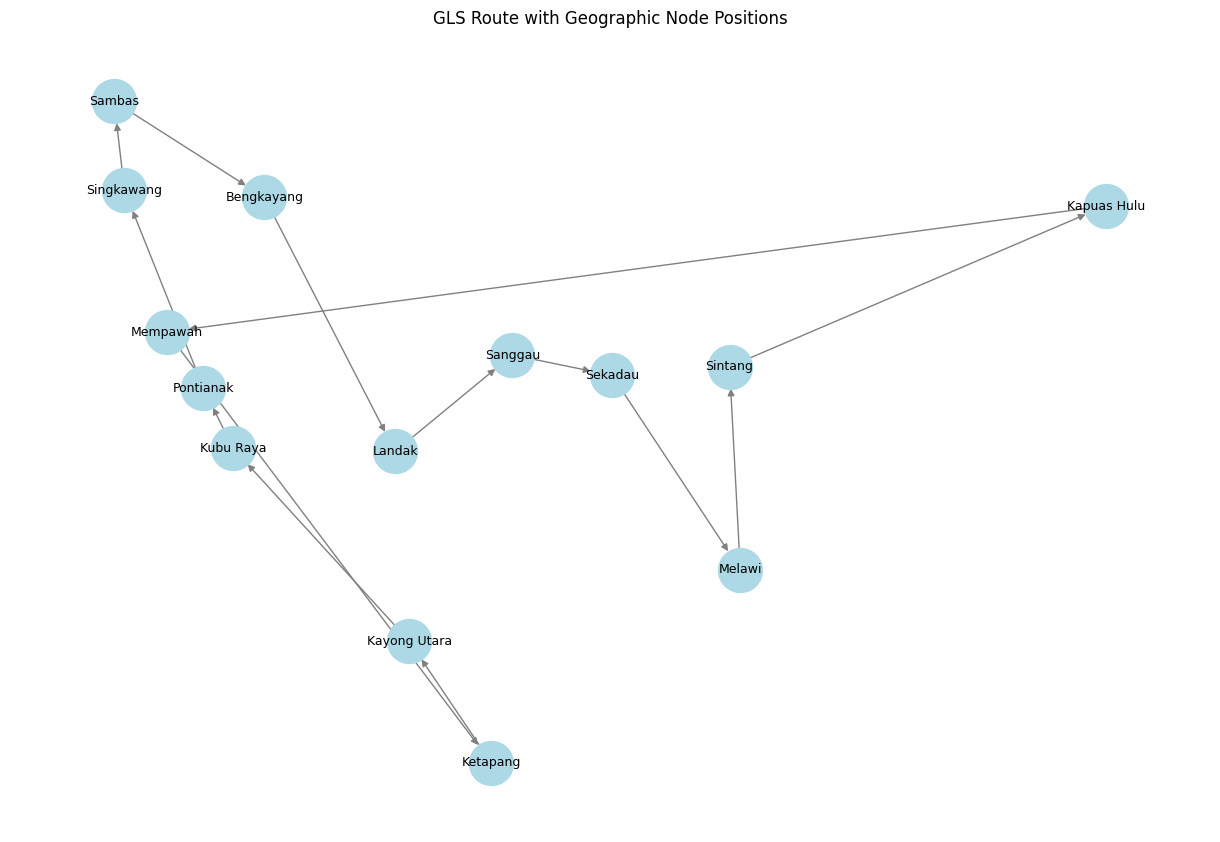

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

geo_pos1 = {
    0: (109.3333, -0.0333),   # Pontianak
    1: (109.0093, 0.9087),    # Singkawang
    2: (108.9667, 1.3333),    # Sambas
    3: (109.5840, 0.8758),    # Bengkayang
    4: (110.1216, -0.3367),   # Landak
    5: (110.6031, 0.1239),    # Sanggau
    6: (111.0134, 0.0261),    # Sekadau
    7: (111.5400, -0.9000),   # Melawi
    8: (111.4960, 0.0679),    # Sintang
    9: (113.0426, 0.8354),    # Kapuas Hulu
    10: (109.1833, 0.2333),   # Mempawah
    11: (110.5161, -1.8210),  # Ketapang
    12: (110.1794, -1.2415),  # Kayong Utara
    13: (109.4544, -0.3201)   # Kubu Raya
}

places = [
    "Pontianak", "Singkawang", "Sambas", "Bengkayang",
    "Landak", "Sanggau", "Sekadau", "Melawi", "Sintang",
    "Kapuas Hulu", "Mempawah", "Ketapang", "Kayong Utara", "Kubu Raya"
]

opt_route = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]
edges = [(opt_route[i], opt_route[i+1]) for i in range(len(opt_route) - 1)]

G = nx.DiGraph()
G.add_edges_from(edges)

labels = {i: places[i] for i in G.nodes()}

plt.figure(figsize=(12, 8))
nx.draw(G, pos=geo_pos1, with_labels=True, labels=labels,
        node_color='lightblue', node_size=1000,
        font_size=9, edge_color='gray', arrows=True)
plt.title("GLS Route with Geographic Node Positions")
plt.show()
